# Setup

**Imports**

In [257]:
import datetime as dt
from math import log
import IPython

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from ruptures.base import BaseCost
from ruptures.metrics import hausdorff

import seaborn as sns

from tqdm import tqdm

rng = np.random.default_rng()

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [258]:
# path to data files
# 
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# changer ici avec le path dans ton repo 
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

datapath = "/home/benjamin/Folders_Python/MVA/AST_TP3/data/"

In [259]:
FS = 22050  # sampling frequency (Hz)

X_train_filepath = datapath + "X_train.npy"
y_train_filepath = datapath + "y_train.npy"

X_train = np.load(X_train_filepath, allow_pickle=True).tolist()
y_train = np.load(y_train_filepath, allow_pickle=True).tolist()

In [260]:
signal, symbols = X_train[2], y_train[2]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

D 6 A 8 3 D 1 8 B 9


In [261]:
def return_symbol(f1,f2):
    """retourne le symbole correspondant aux deux fréquences f1 et f2
    """
    
    fmin = int(np.min([f1,f2]))
    fmax = int(np.max([f1,f2]))
    
    dico = {
        "1" : [697,1209],
        "2" : [697,1336],
        "3" : [697, 1477],
        "A" : [697, 1633],
        "4" : [770, 1209],
        "5" : [770, 1336],
        "6" : [770, 1477],
        "B" : [770, 1633],
        "7" : [852, 1209],
        "8" : [852, 1336],
        "9" : [852, 1477],
        "C" : [852, 1633],
        "*" : [941, 1209],
        "0" : [941, 1336],
        "#" : [941, 1477],
        "D" : [941, 1633]
    }
    
    for k,v in dico.items():
        if v == [fmin, fmax]:
            return k
    print(f'no key corresponding to {fmin, fmax}')
    return None

### Validating a pipeline

The time representation is pretty useless

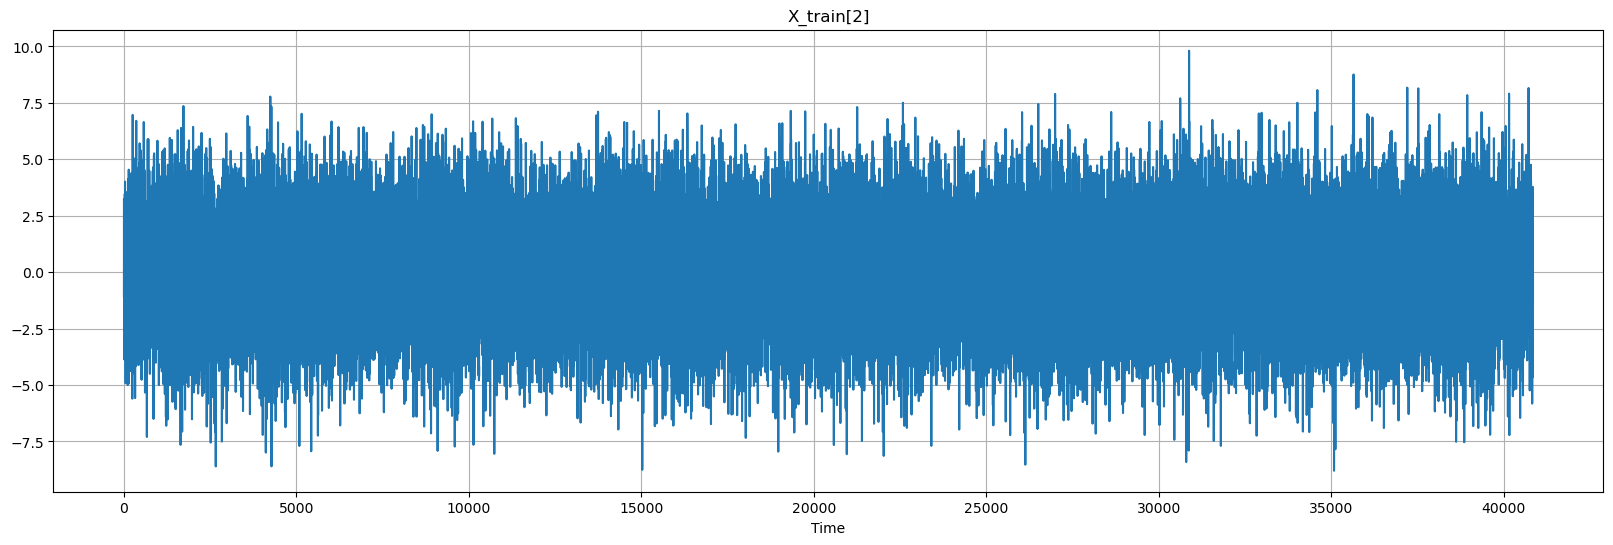

In [262]:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(signal)
ax.grid(True)
ax.set_title("X_train[2]")
ax.set_xlabel('Time')
plt.show()

Let's plot the spectrogram : we can see 10 pairs, separated by silences, and an added noise whose frequency varies as a sine.

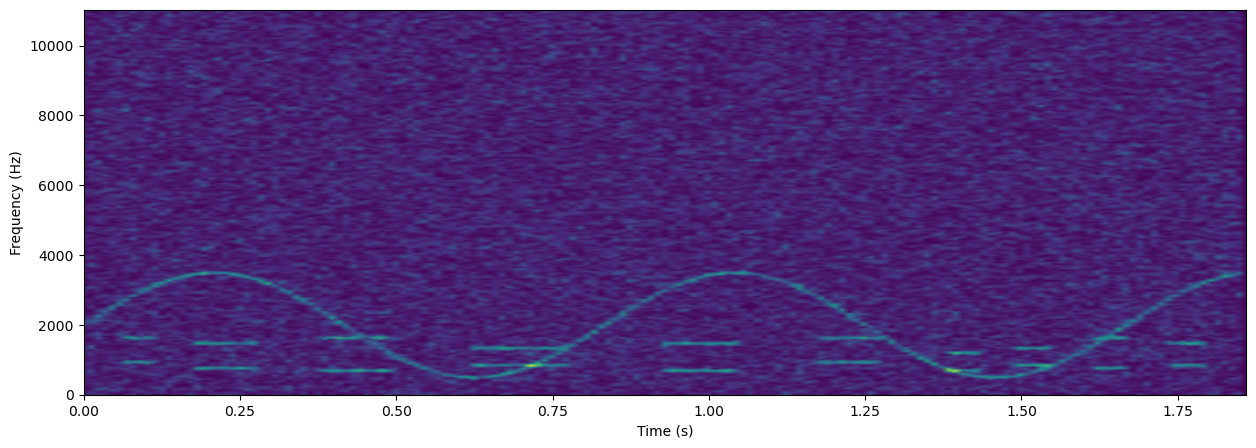

In [263]:
from scipy.signal import stft
FREQUENCY = 22050

def fig_ax(figsize=(15, 5)):
    return plt.subplots(figsize=figsize)

f, t, Zxx = stft(signal, fs=FREQUENCY, nperseg=500, noverlap=None)

fig, ax = fig_ax()
ax.pcolormesh(t, f, np.abs(Zxx), vmin=0, shading="gouraud")
ax.set_xlabel("Time (s)")
_ = ax.set_ylabel("Frequency (Hz)")

In [264]:
print(f'signal = {signal.shape}')
print(f't = {t.shape} fenêtres')
print(f'f = {f.shape} frequences par DFT')
print(f'|Zxx| = {np.abs(Zxx).shape}')

signal = (40847,)
t = (165,) fenêtres
f = (251,) frequences par DFT
|Zxx| = (251, 165)


In [265]:
# first, filter around frequencies of interest

foi = [697, 770, 852, 941, 1209,1336, 1477, 1633]  # frequencies of interest
tolerance = 0

In [266]:
def extract_Zxx_net(Zxx):
    
    # extract data for frequencies of interest
    Zxx_net = np.zeros(shape=Zxx.shape)
    for i,freq in enumerate(foi):
        id_low = np.argwhere(f <= (freq-tolerance))[-1][0]
        id_high = np.argwhere(f >= (freq+tolerance))[0][0]
        nb_ind = id_high - id_low +1
        if i==0:
            Zxx_net = Zxx[id_low:id_high+1,:]
            freq_display = f[id_low:id_high+1]
        else:
            Zxx_net = np.concatenate( [Zxx_net, Zxx[id_low:id_high+1,:]], axis=0)
            freq_display = np.concatenate( [freq_display, f[id_low:id_high+1]], axis=0)
            
    return Zxx_net, freq_display

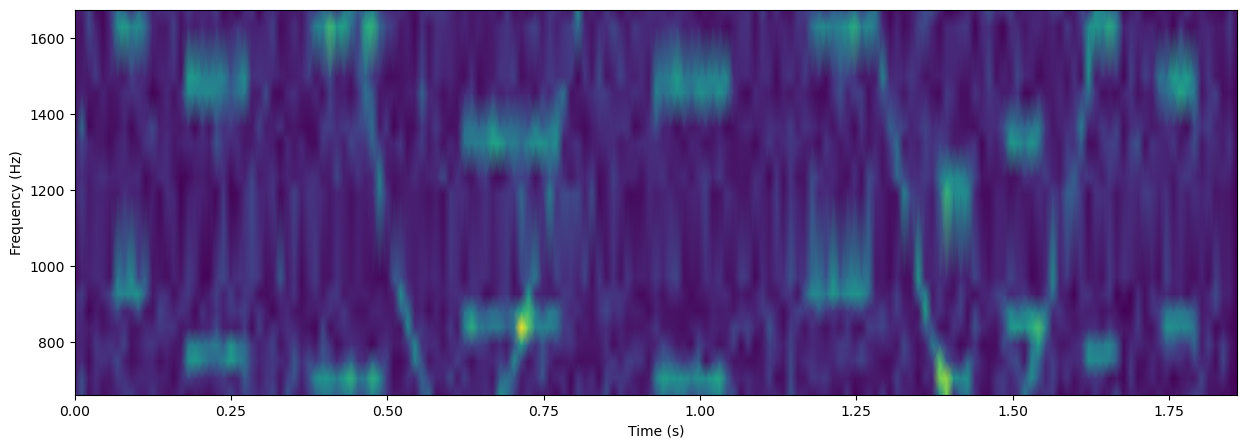

In [267]:
Zxx_net = np.zeros(shape=Zxx.shape)
Zxx_net, freq_display = extract_Zxx_net(Zxx)

fig, ax = fig_ax()
ax.pcolormesh(t, freq_display, np.abs(Zxx_net), vmin=0, shading="gouraud")
ax.set_xlabel("Time (s)")
_ = ax.set_ylabel("Frequency (Hz)")

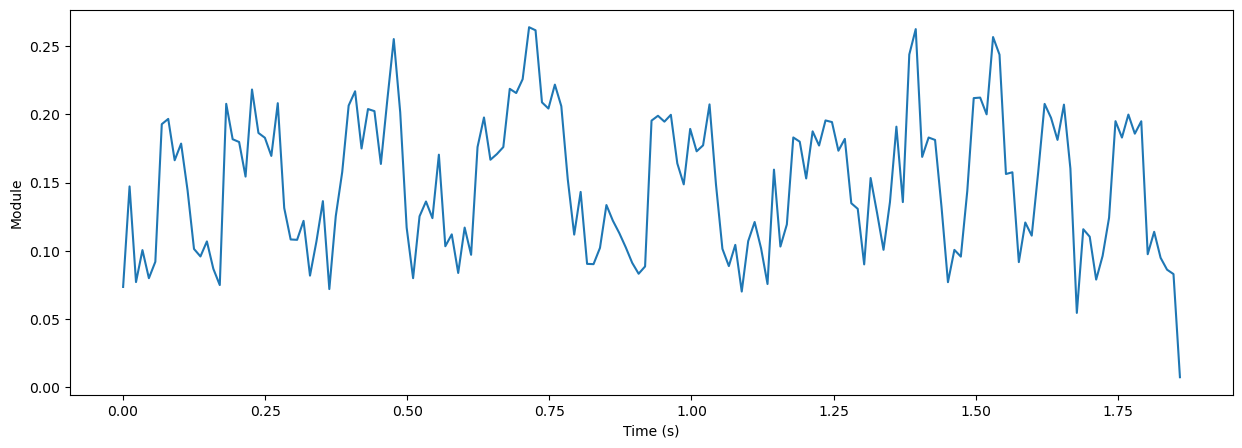

In [268]:
# plot average energy per window

avg_nrj = np.mean(np.abs(Zxx_net), axis=0).reshape(-1,)

fig, ax = fig_ax()
ax.plot(t,avg_nrj)
ax.set_xlabel("Time (s)")
_ = ax.set_ylabel("Module")

Found 21 break points vs 10 symboles


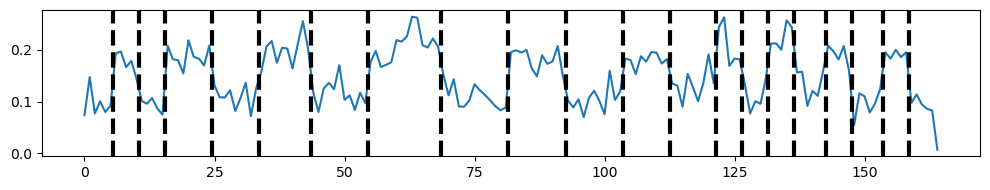

In [269]:
# Now, use change-point detection algorithm on average value, with BIC criterion, to separate silences from dial-tones

# noise_std = np.std(avg_nrj)/2
# noise_std = np.mean(np.std(np.abs(Zxx_net), axis=0))

noise_std = 0.03 # how to optimize ?
pen_bic = 2 * np.log(len(avg_nrj)) * noise_std**2
signal = avg_nrj.reshape(-1,1)

predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(signal=signal, pen=pen_bic)
print(f'Found {len(predicted_bkps)} break points vs {len(symbols)} symboles')

fig, ax_arr = rpt.display(signal, [], predicted_bkps)
# print(f"error: {hausdorff([], predicted_bkps)} samples")

In [270]:
def predict_symbols(Z_net, pred_bkps):
    
    # loop over segments and classify
    i_min = 0
    signal_threshold = np.mean(np.abs(Z_net))  # average enegy above which there is a dial tone, under which this is silence
    list_symbols = []

    for i_max in pred_bkps:
        nrj = np.mean(np.abs(Z_net[:,i_min:i_max]))
        # print(f'Looking at segment {i_min},{i_max} : nrj = {nrj}')
        if nrj <= signal_threshold:
            # print(f'segment between {i_min},{i_max} : silence')
            pass
        else:
            # il y a un signal
            list_freqs = []
            for j, freq in enumerate(foi):
                nrj_freq = np.mean(np.abs(Z_net[j*2:j*2+1,i_min:i_max]))
                if nrj_freq > signal_threshold:
                    # {i_min},{i_max} : 
                    # print(f'Frequence {freq} is active dans segment {i_min},{i_max}')
                    list_freqs.append(freq)
            if len(list_freqs) <= 1:
                msg = f"une seule fréquence active trouvée dans une bande d'énergie!"
            if len(list_freqs) == 2:
                symbole = return_symbol(list_freqs[0], list_freqs[1])
                msg = f"symbole trouvé = {symbole}"
            if len(list_freqs) >= 3:
                symbole = return_symbol(np.min(list_freqs), np.max(list_freqs))
                msg = f"Trois fréquences actives trouvées ou plus - symbole choisi random : {symbole} avec {np.min(list_freqs)} et {np.max(list_freqs)}"
            # print(f'segment between {i_min},{i_max} : ' + msg)
            list_symbols.append(symbole)
            
        i_min = i_max
        
    return list_symbols

In [271]:
print(f"\n")
print(f"Ground truth = {symbols}")
list_symbols = predict_symbols(Z_net=Zxx_net, pred_bkps=predicted_bkps)
print(f"Prediction = {list_symbols}")



Ground truth = ['D', '6', 'A', '8', '3', 'D', '1', '8', 'B', '9']
Prediction = ['D', '6', 'A', '8', '3', 'D', '1', '2', 'B', '9']


### Optimizing hyperparameters

Hyperparameters to otpimize :
- nperseg dans STFT
- noise_std dans BIC pour PELT

Metric :
- nombre de break points, doit proche du nombre de symboles ground truth x 2 + 1

In [272]:
foi = [697, 770, 852, 941, 1209,1336, 1477, 1633]  # frequencies of interest
tolerance = 0

results = {}

list_nperseg = np.linspace(100, 2000, endpoint=True, num=20)
print(f"nprseg : {list_nperseg}")
list_noise_std = np.linspace(0.01, 0.05, endpoint=True, num=20)
print(f"noise_std = {list_noise_std}")

nprseg : [ 100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100. 1200.
 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000.]
noise_std = [0.01       0.01210526 0.01421053 0.01631579 0.01842105 0.02052632
 0.02263158 0.02473684 0.02684211 0.02894737 0.03105263 0.03315789
 0.03526316 0.03736842 0.03947368 0.04157895 0.04368421 0.04578947
 0.04789474 0.05      ]


In [273]:
xp = 0
xp_total = len(list_nperseg) * len(list_noise_std)

for nperseg in list_nperseg:
    for noise_std in list_noise_std:
        
        # print(f"Training for nperseg = {nperseg}, noise_std = {noise_std}")
        print(f"Running xp {xp+1} / {xp_total}", end="\r")
        
        list_errors = []
        for n, (signal, symbols) in enumerate(zip(X_train, y_train)):
            
            # for debug purposes
            # ------------------
            # if i%20 == 0:
            #     print(f"i = {i}")
            #     print(f"signal = {signal}")
            #     print(f"{signal.shape}")
            #     print(f"symbols = {symbols}")
            
            # calculate spectrogram
            f, t, Zxx = stft(signal, fs=FREQUENCY, nperseg=nperseg, noverlap=None)
            
            # extract data for frequencies of interest
            Zxx_net, freq_display = extract_Zxx_net(Zxx)
            
            # run change-point detection on energy signal for frequencies of interest
            avg_nrj = np.mean(np.abs(Zxx_net), axis=0).reshape(-1,)
            pen_bic = 2 * np.log(len(avg_nrj)) * noise_std**2
            signal_2 = avg_nrj.reshape(-1,1)
            predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(signal=signal_2, pen=pen_bic)
            
            # absolute error between predicted number of break points and target
            list_errors.append(np.abs(len(predicted_bkps) - (2*len(symbols)+1)))
            
        # log results
        results[xp] = [nperseg, noise_std, list_errors]
        xp += 1

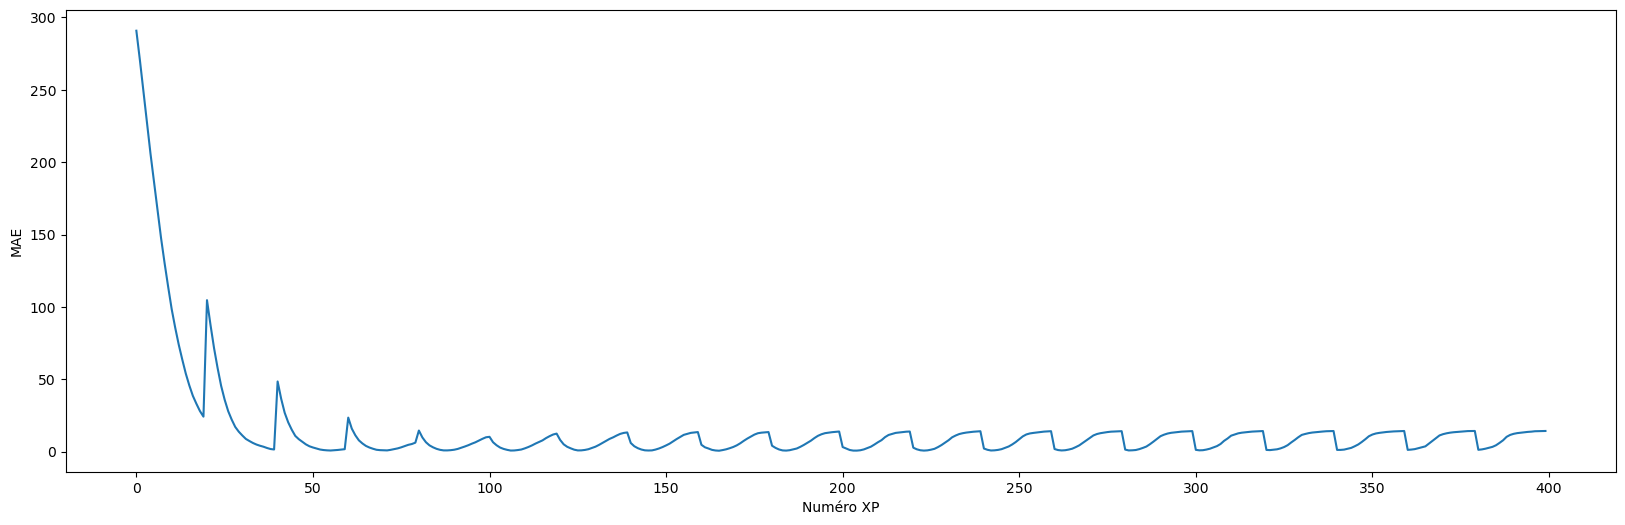

In [274]:
# plotting best results

mean_results = { xp : [ v[0], v[1], np.mean(v[2])] for xp, v in results.items()}

scores = np.zeros(shape=(len(mean_results)))
for i in range(len(mean_results)):
    scores[i] = mean_results.get(i)[2]
    
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(scores)
ax.set_xlabel(f"Numéro XP")
ax.set_ylabel(f"MAE")

best = np.argmin(scores)

In [275]:
# best hyperparameters

best_nperseg = results.get(best)[0]
best_noise_std = results.get(best)[1]

print(f"Best XP is number {best}, with nperseg = {best_nperseg}, noise_std = {best_noise_std}, MAE = {scores[best]}")

Best XP is number 165, with nperseg = 900.0, noise_std = 0.020526315789473684, MAE = 0.57


In [276]:
# check hyperparameters on random signals in dataset
N = 10
id_random_samples = np.random.choice(range(len(X_train)), size=N)

for id in id_random_samples:
    
    # get sample
    signal, gt_symbols = X_train[id], y_train[id]
    
    # calculate spectrogram
    f, t, Zxx = stft(signal, fs=FREQUENCY, nperseg=best_nperseg, noverlap=None)
    
    # extract data for frequencies of interest
    Zxx_net, freq_display = extract_Zxx_net(Zxx)
    
    # run change-point detection on energy signal for frequencies of interest
    avg_nrj = np.mean(np.abs(Zxx_net), axis=0).reshape(-1,)
    pen_bic = 2 * np.log(len(avg_nrj)) * best_noise_std**2
    signal_2 = avg_nrj.reshape(-1,1)
    predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(signal=signal_2, pen=pen_bic)
    
    # check
    print(f"\n")
    print(f"Ground truth = {gt_symbols}")
    list_symbols = predict_symbols(Z_net=Zxx_net, pred_bkps=predicted_bkps)
    print(f"Prediction = {list_symbols}")   




Ground truth = ['4', '8', '6', '*']
Prediction = ['4', '8', '6', '*']


Ground truth = ['7', '4', '2', '*', '1', '1']
Prediction = ['7', '2', '1', '1', '3']


Ground truth = ['5', '6', '7', 'A', 'A', '9', '8', '2', 'A', 'D', '3']
Prediction = ['5', 'B', '1', 'A', 'A', '9', '2', '2', 'A', 'C', '3']


Ground truth = ['7', 'A', '0', '1']
Prediction = ['7', 'A', '2', '1']


Ground truth = ['2', '9', 'B', '9', '8', '5', '1']
Prediction = ['2', '9', 'B', '9', '8', '2', '1']


Ground truth = ['5', '8', '*', '7', '2']
Prediction = ['5', '8', '1', '7', '2']


Ground truth = ['6', '*', 'C', 'A', '8', 'B', '*', '2', '9']
Prediction = ['6', '*', 'C', 'A', '5', 'B', '*', '2', '3']


Ground truth = ['3', '7', '8', 'D', '9', 'A', '8', '9', '9', '*', '3']
Prediction = ['3', '7', '2', 'D', '9', 'A', '8', '9', '9', '1', '3']


Ground truth = ['7', '5', '9', '7', '4', '*', '9', 'D']
Prediction = ['7', '5', '9', '4', '1', '9', 'D']


Ground truth = ['2', '9', 'B', '9', '8', '5', '1']
Prediction = ['2', 

# Question 2

In [277]:
X_test_filepath = datapath + "X_test.npy"

X_test = np.load(X_test_filepath, allow_pickle=True).tolist()

In [278]:
for signal in X_test:
          
    # calculate spectrogram
    f, t, Zxx = stft(signal, fs=FREQUENCY, nperseg=best_nperseg, noverlap=None)
    
    # extract data for frequencies of interest
    Zxx_net, freq_display = extract_Zxx_net(Zxx)
    
    # run change-point detection on energy signal for frequencies of interest
    avg_nrj = np.mean(np.abs(Zxx_net), axis=0).reshape(-1,)
    pen_bic = 2 * np.log(len(avg_nrj)) * best_noise_std**2
    signal_2 = avg_nrj.reshape(-1,1)
    predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(signal=signal_2, pen=pen_bic) 
        
    print(f"\n")
    list_symbols = predict_symbols(Z_net=Zxx_net, pred_bkps=predicted_bkps)
    print(f"Prediction = {list_symbols}")



Prediction = ['7', '2', '3', '9', '6']


Prediction = ['1', '#', '2', '#']


# Question 3

# Question 4

# Question 5

# Question 6

# Question 7